In [ ]:
from rich import inspect
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from einops.layers.keras import Rearrange, Reduce

# Construir la entrada de prueba

Lo primero que vamos a hacer es contruir una señal de entrada que nos permita visualizar el resultado de las diferentes operaciones que vamos a ir realizando. Siempre es buena idea utilizar una entrada que sabemos el resultado que tiene que producir cuando queremos comprobar el funcionamiento de alguna herramienta nueva.

En este caso generaremos una imágen cuyas filas tienen distintos colores, siendo el color igual en toda la fila.

In [21]:
red = np.ones(shape=(1,3,3))*np.array([1,0,0])
blue = np.ones(shape=(1,3,3))*np.array([0,1,0])
yellow = np.ones(shape=(1,3,3))*np.array([0,0,1])
sample = np.concatenate([red, blue, yellow])
sample.shape

(3, 3, 3)

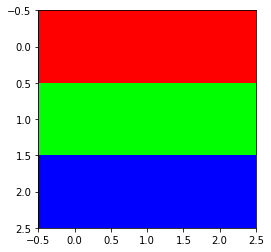

In [22]:
plt.imshow(sample)
plt.show()

Le añadimos la dimensión del batch porque las capas de Keras esperan que la tenga aunque sea solo una muestra:

In [25]:
sample = np.expand_dims(sample, 0)
sample.shape

(1, 3, 3, 3)

# Flatten

In [26]:
sample_flatten_layer = layers.Flatten()(sample).numpy()
sample_flatten_einops = Rearrange("b h w c -> b (h w c)")(sample).numpy()

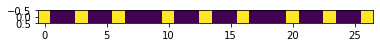

In [28]:
plt.imshow(sample_flatten_layer)
plt.show()

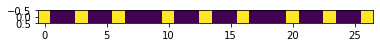

In [29]:
plt.imshow(sample_flatten_einops)
plt.show()

In [ ]:
assert np.allclose(sample_flatten_layer, sample_flatten_einops)

Hemos comprobado que las dos operaciones producen el mismo resultado, pero la visualización no es especialmente útil porque al estirar completamente la imagen, hemos perdido la información de los colores. Podemos repetirlo con una imagen en escala de grises para verlo un poco mejor:

In [33]:
np.linspace(0,255,9)

array([  0.   ,  31.875,  63.75 ,  95.625, 127.5  , 159.375, 191.25 ,
       223.125, 255.   ])

In [41]:
sample_bw = np.array([[0, 31, 63],
                      [95, 127, 159],
                      [191, 223, 255]])
sample_bw.shape

(3, 3)

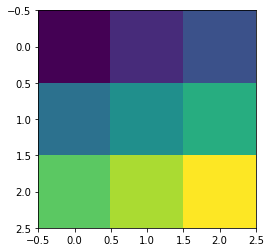

In [42]:
plt.imshow(sample_bw)
plt.show()

In [43]:
sample_bw = np.expand_dims(sample_bw, 0)
sample_bw = np.expand_dims(sample_bw, -1)
sample_bw.shape

(1, 3, 3, 1)

In [44]:
sample_flatten_layer_bw = layers.Flatten()(sample_bw).numpy()
sample_flatten_einops_bw = Rearrange("b h w c -> b (h w c)")(sample_bw).numpy()

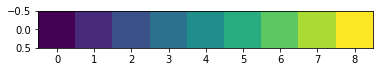

In [46]:
plt.imshow(sample_flatten_layer_bw)
plt.show()

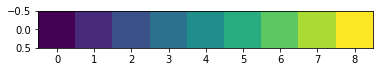

In [47]:
plt.imshow(sample_flatten_einops_bw)
plt.show()

Ahora sí que somos capaces de ver fácilmente que las operaciones se realizan de la misma manera y que, además, la capa `Flatten()` se aplica estirando primero las filas.

## Mantiendo la dimensión de los canales

Como hemos podido ver, una de las desventajas de estirar la imagen completa es que perdemos la información de los colores. Lo bonito de utilizar `einops` es que podemos especificar que queremos estirar únicamente las dimensiones de *alto* y *ancho*, pero que queremos dejar igual la dimensión de los canales. De esta forma podemos mantener la misma información de color que en la imagen original, lo que facilita la intepretación de la operación.

Algo que nos planteamos al utilizar `Flatten()` es por qué dimensión empezamos a estirar los datos. En cambio, al utilizar `einops` estamos haciendo esta elección, ya que somos nosotros los que elegimos el orden al escribir la operación. Por ejemplo, al escribir `"b h w c -> b (h w) c"`, estamos indicando que queremos estirar primero las filas y luego las columnas. En cambio, al escribir `"b h w c -> b (w h) c"`, estaremos estirando primero las columnas y luego las filas. Podemos ver como cambian los resultados:

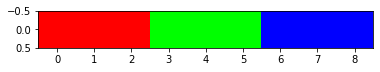

In [30]:
sample_flatten_einops = Rearrange("b h w c -> b (h w) c")(sample).numpy()
plt.imshow(sample_flatten_einops)
plt.show()

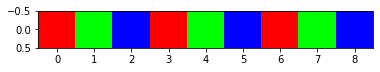

In [31]:
sample_flatten_einops = Rearrange("b h w c -> b (w h) c")(sample).numpy()
plt.imshow(sample_flatten_einops)
plt.show()

En el primer caso vemos como la operación va recorriendo las filas y colocándolas una al lado de la otra (lo que se podría entender como estirar las filas), mientras que en el segundo caso sucede lo mismo con las columnas; se coge la primera columna, se estira y se repite el proceso con las siguientes columnas.

En muchos casos puede que no sea necesario conocer el funcionamiento detallado de estas operaciones, pero es un ejercicio interesante y no está de más tener claro cómo s eestán aplicando exactamente las operaciones que vamos realizando.

# Pooling

## Creación de la entrada

In [52]:
sample_maxpool_layer = layers.MaxPool2D(3)(sample).numpy()
sample_maxpool_einops = Reduce("b (h h2) (w w2) c -> b h w c", "max", h2=3, w2=3)(sample).numpy()

sample_maxpool_layer.shape, sample_maxpool_einops.shape

((1, 1, 1, 3), (1, 1, 1, 3))

In [54]:
sample_maxpool_layer.squeeze(), sample_maxpool_einops.squeeze()

(array([1., 1., 1.], dtype=float32), array([1., 1., 1.], dtype=float32))

In [58]:
assert np.allclose(sample_maxpool_layer, sample_maxpool_einops)

In [ ]:
assert (layers.AveragePooling2D(2)(sample).numpy() == Reduce("b (h h2) (w w2) c -> b h w c", "mean", h2=2, w2=2)(sample).numpy()).all()

In [ ]:
assert (layers.GlobalAveragePooling2D()(sample).numpy() == Reduce("b h w c -> b (h w c)", "mean")(sample).numpy()).all()